Epoch [500/75000], Loss: 1162075.0000
Epoch [1000/75000], Loss: 634609.0625
Epoch [1500/75000], Loss: 339477.9375
Epoch [2000/75000], Loss: 163168.0625
Epoch [2500/75000], Loss: 75489.0000
Epoch [3000/75000], Loss: 32034.2969
Epoch [3500/75000], Loss: 15385.8926
Epoch [4000/75000], Loss: 9478.4980
Epoch [4500/75000], Loss: 7868.4653
Epoch [5000/75000], Loss: 7062.6055
Epoch [5500/75000], Loss: 6509.5176
Epoch [6000/75000], Loss: 6017.3574
Epoch [6500/75000], Loss: 5791.3066
Epoch [7000/75000], Loss: 5607.5659
Epoch [7500/75000], Loss: 5520.5518
Epoch [8000/75000], Loss: 5466.9043
Epoch [8500/75000], Loss: 5445.0117
Epoch [9000/75000], Loss: 5433.4961
Epoch [9500/75000], Loss: 5418.7964
Epoch [10000/75000], Loss: 5406.3062
Epoch [10500/75000], Loss: 5404.3125
Epoch [11000/75000], Loss: 5349.4492
Epoch [11500/75000], Loss: 5402.6934
Epoch [12000/75000], Loss: 5396.2476
Epoch [12500/75000], Loss: 5390.6489
Epoch [13000/75000], Loss: 5384.2939
Epoch [13500/75000], Loss: 5360.8193
Epoch [14

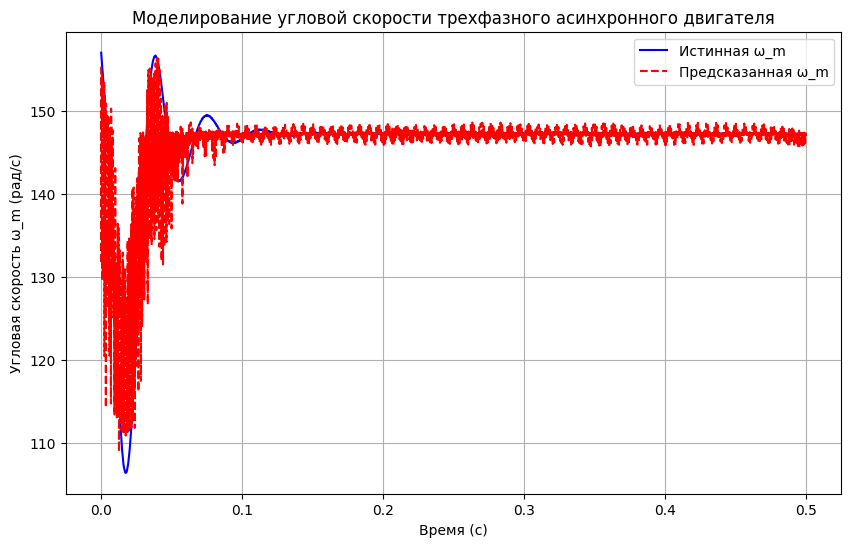

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Устройство для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Параметры двигателя
P_n = 4000  # Номинальная мощность, ВА
V_n = 400  # Номинальное напряжение, В (RMS)
f_n = 50  # Частота, Гц
R_s = 1.405  # Сопротивление статора, Ом
L_ls = 0.005839  # Индуктивность рассеяния статора, Гн
R_r = 1.395  # Сопротивление ротора, Ом
L_lr = 0.005839  # Индуктивность рассеяния ротора, Гн
L_m = 0.1722  # Взаимная индуктивность, Гн
J = 0.0131  # Момент инерции, кг·м²
F = 0.002985  # Коэффициент трения, Н·м·с
p = 2  # Число пар полюсов
S = 4000  # Полная мощность, ВА
w0 = 2 * np.pi * f_n  # Синхронная угловая скорость
H = (J * w0**2) / (2 * S)  # Постоянная инерции

# Вычисляем полные индуктивности
L_s = L_ls + L_m
L_r = L_lr + L_m

# Загрузка данных
df = pd.read_csv('input.csv')
t_data = torch.tensor(df['time'].values, dtype=torch.float32).reshape(-1, 1).to(device)
v_ds_data = torch.tensor(df['vds'].values, dtype=torch.float32).reshape(-1, 1).to(device)
v_qs_data = torch.tensor(df['vqs'].values, dtype=torch.float32).reshape(-1, 1).to(device)
w_m_data = torch.tensor(df['wm'].values, dtype=torch.float32).reshape(-1, 1).to(device)
tm_data = torch.tensor(1.1853e-3 * w_m_data.cpu().numpy()**2, dtype=torch.float32).reshape(-1, 1).to(device)

# Нейронная сеть
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # Входы: t, v_ds, v_qs
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 9)  # Выходы: i_qs, i_ds, i_qr, i_dr, phi_qs, phi_ds, phi_qr, phi_dr, w_m
        )
    
    def forward(self, t, v_ds, v_qs):
        inputs = torch.cat([t, v_ds, v_qs], dim=1)
        outputs = self.net(inputs)
        i_qs, i_ds, i_qr, i_dr, phi_qs, phi_ds, phi_qr, phi_dr, w_m = outputs.split(1, dim=1)
        return i_qs, i_ds, i_qr, i_dr, phi_qs, phi_ds, phi_qr, phi_dr, w_m

# Функция для вычисления производных
def compute_derivatives(model, t, v_ds, v_qs):
    t.requires_grad_(True)
    i_qs, i_ds, i_qr, i_dr, phi_qs, phi_ds, phi_qr, phi_dr, w_m = model(t, v_ds, v_qs)
    
    # Производные по времени
    dphi_qs_dt = torch.autograd.grad(phi_qs.sum(), t, create_graph=True)[0]
    dphi_ds_dt = torch.autograd.grad(phi_ds.sum(), t, create_graph=True)[0]
    dphi_qr_dt = torch.autograd.grad(phi_qr.sum(), t, create_graph=True)[0]
    dphi_dr_dt = torch.autograd.grad(phi_dr.sum(), t, create_graph=True)[0]
    dw_m_dt = torch.autograd.grad(w_m.sum(), t, create_graph=True)[0]
    
    return i_qs, i_ds, i_qr, i_dr, phi_qs, phi_ds, phi_qr, phi_dr, w_m, dphi_qs_dt, dphi_ds_dt, dphi_qr_dt, dphi_dr_dt, dw_m_dt

# Функция потерь
def loss_fn(model, t, v_ds, v_qs, w_m_data, tm_data):
    i_qs, i_ds, i_qr, i_dr, phi_qs, phi_ds, phi_qr, phi_dr, w_m, dphi_qs_dt, dphi_ds_dt, dphi_qr_dt, dphi_dr_dt, dw_m_dt = compute_derivatives(model, t, v_ds, v_qs)
    
    # Уравнения напряжений
    omega = w0  # Синхронная скорость
    omega_r = w_m * p  # Электрическая угловая скорость
    residual_v_qs = v_qs - (R_s * i_qs + dphi_qs_dt + omega * phi_ds)
    residual_v_ds = v_ds - (R_s * i_ds + dphi_ds_dt - omega * phi_qs)
    residual_v_qr = 0 - (R_r * i_qr + dphi_qr_dt + (omega - omega_r) * phi_dr)
    residual_v_dr = 0 - (R_r * i_dr + dphi_dr_dt - (omega - omega_r) * phi_qr)
    
    # Уравнения потокосцеплений
    residual_phi_qs = phi_qs - (L_s * i_qs + L_m * i_qr)
    residual_phi_ds = phi_ds - (L_s * i_ds + L_m * i_dr)
    residual_phi_qr = phi_qr - (L_r * i_qr + L_m * i_qs)
    residual_phi_dr = phi_dr - (L_r * i_dr + L_m * i_ds)
    
    # Электромагнитный момент
    T_e = 1.5 * p * (phi_ds * i_qs - phi_qs * i_ds)
    
    # Механическое уравнение
    residual_w_m = dw_m_dt - (1 / (2 * H)) * (T_e - F * w_m - tm_data)
    
    # Потери от уравнений
    loss_phys = (residual_v_qs**2 + residual_v_ds**2 + residual_v_qr**2 + residual_v_dr**2 +
                 residual_phi_qs**2 + residual_phi_ds**2 + residual_phi_qr**2 + residual_phi_dr**2 +
                 residual_w_m**2).mean()
    
    # Потери от данных
    loss_data = ((w_m - w_m_data)**2).mean()
    
    # Общая потеря
    return loss_phys + 100 * loss_data  # Увеличиваем вес данных

# Инициализация модели и оптимизатора
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# Обучение
epochs = 75_000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, v_ds_data, v_qs_data, w_m_data, tm_data)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Предсказание и визуализация
with torch.no_grad():
    _, _, _, _, _, _, _, _, w_m_pred = model(t_data, v_ds_data, v_qs_data)
    w_m_pred = w_m_pred.cpu().numpy()
    w_m_data = w_m_data.cpu().numpy()
    t_data = t_data.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(t_data, w_m_data, label='Истинная ω_m', color='blue')
plt.plot(t_data, w_m_pred, label='Предсказанная ω_m', linestyle='--', color='red')
plt.xlabel('Время (с)')
plt.ylabel('Угловая скорость ω_m (рад/с)')
plt.title('Моделирование угловой скорости трехфазного асинхронного двигателя')
plt.legend()
plt.grid(True)
plt.show()